# Set up Google Colab

This means mounting drive and importing

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Lab/Grain-U-Net'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.

# %cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME
#!pip install
#4/1AY0e-g5h4eZedG3k6mfdIj0OYbR717PFyEhKuxK5PidsrBbPRxi8fge6E3c

Mounted at /content/drive
/content/drive/My Drive/Lab/Grain-U-Net


In [ ]:
from model import *
from data import *

# Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.00,
                    height_shift_range=0.00,
                    shear_range=0.00,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/train','image','label',data_gen_args,save_to_dir = 'data/train/aug')
model = unet()
model_checkpoint = ModelCheckpoint('unet_grain.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])

### Train with npy file

In [ ]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

In [ ]:
%ls

### test your model and save predicted results

In [ ]:
testGene = testGenerator("data/test")
model = unet()
model.load_weights("unet_grain.hdf5")
results = 255 * model.predict_generator(testGene, 23, verbose=1)
saveResult("data/test", results.astype('uint8'))
# print(results.shape)
# io.imshow(results[22, :, :, 0])

# Small Post Processing Stage

This next thing is just to visualize what the processing is doing before applying it to all the images

In [ ]:
from skimage import data, io, filters, morphology
import numpy as np
import matplotlib.pyplot as plt

def imsubplot(ax, im, cmap="gray", title=None):
    ax.imshow(im, cmap=cmap)
    ax.axis("off")
    if title:
        ax.set_title(title)

def post_process(path, thresh=255, verbose=False):
    image = io.imread(path)
    threshold = np.zeros(image.shape)
    threshold[image < thresh] = 1
    skeleton = morphology.skeletonize(threshold)
    
    if verbose:
        fig, (a, b, c) = plt.subplots(ncols=3)
        
        imsubplot(a, image, title='UNET Output')
        imsubplot(b, threshold, title='Threshold')
        imsubplot(c, skeleton, title='Skeleton')
        plt.show()
    else:
        return skeleton

post_process('data/test/0_predict.png', thresh=250, verbose=True)

#### This is to apply this processing to all the boundaries

In [ ]:
test_n = 23
test_dir = 'data/test/'

for i in range(test_n):
    im_path = f'{test_dir}{i}_predict.png'
    skel = 255 * post_process(im_path, thresh=250)
    io.imsave(f'{test_dir}{i}_processed.png', skel.astype('uint8')) 

# Overlay 

In [ ]:
from skimage import io, transform
import numpy as np

test_n = 23
test_dir = 'data/test/'

for i in range(test_n):
    raw_img = io.imread(f'{test_dir}{i}.png')
    sk_img = io.imread(f'{test_dir}{i}_processed.png')
    sk_img = 255 * transform.resize(sk_img, raw_img.shape, anti_aliasing=False)
    fusion_img = np.zeros((raw_img.shape[0], raw_img.shape[1], 3), dtype=int)
    fusion_img[:, :, 0] = raw_img
    fusion_img[:, :, 1] = raw_img
    fusion_img[:, :, 2] = raw_img
    fusion_img[sk_img > 0, 0] = 255

    io.imsave(f'{test_dir}{i}_overlaid.png', fusion_img.astype('uint8')) 
#    io.imshow(fusion_img)
#    io.show()

# Chi2

In [2]:
from chi2test import find_chi2
from skimage import io, transform
import os
import numpy as np

test_dir = 'data/test/'
traced_dir = 'data/test/key/'
traced_names = os.listdir(traced_dir)
traced = np.char.strip(traced_names, '.png')

for key in traced:
    ml_img = io.imread(test_dir + key + '_processed.png')
    key_img = transform.resize(io.imread(traced_dir + key + '.png'), ml_img.shape)

    if np.min(key_img) != 0 or np.max(key_img) != 255:
        key_img -= np.min(key_img)
        key_img = np.round(key_img * (255 / np.max(key_img)))
    key_img = np.max(key_img) - key_img

    results = find_chi2(ml_img, key_img, out_dict=True)
    print(f'Image {key}:\t {results["chi2"]} \t {results["avg_chi2"]}')
    '''
    fuse_size = np.maximum(key_img.shape, ml_img.shape)
    def fuse(out, img, offset_x=0, offset_y=0):
        buf_x = out.shape[0] - img.shape[0]
        buf_y = out.shape[1] - img.shape[1]
        img = np.round(img * (255 / np.max(img)))
        out[buf_x//2 + offset_x : -buf_x//2 + offset_x, buf_y//2 + offset_y : -buf_y//2 + offset_y] = img

    fuse_img = np.zeros((fuse_size[0] + 2, fuse_size[1] + 2, 3), dtype=int)
    fuse(fuse_img[:,:,0], ml_img)
    fuse(fuse_img[:,:,1], key_img)
    io.imshow(fuse_img)
    io.show()
'''

Image 3:	 36192 	 14.570048309178745
Image 2:	 2642 	 1.110550651534258
Image 0:	 33696 	 14.302207130730052
Image 1:	 17453 	 5.896283783783784
Image 4:	 166350 	 85.2202868852459
Image 6:	 32097 	 14.88038942976356
Image 7:	 108598 	 36.63900134952767
Image 9:	 45601 	 18.052652414885195
Image 11:	 205932 	 81.7514886859865
Image 12:	 36834 	 17.674664107485604
Image 5:	 55402 	 19.562853107344633
Image 8:	 38225 	 14.534220532319392
Image 10:	 65879 	 22.53043775649795


## Broken Chi2 Alignment (Don't use, the descent function is really bad)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


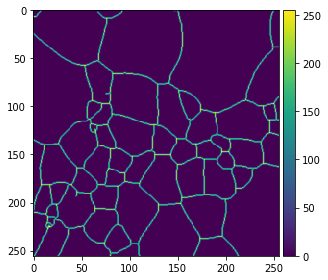

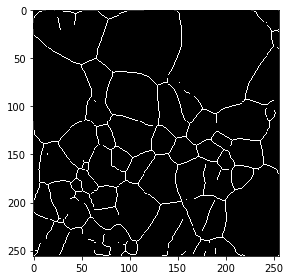

ValueError: ignored

In [2]:
from chi2test import *
from skimage import io, transform
import numpy as np

traced_n = 13
traced_dir = 'data/test/key/'

ml_img = io.imread('data/test/5_processed.png')
key_img = transform.resize(io.imread('data/test/key/5.png'), ml_img.shape)

if np.min(ml_img) != 0 or np.max(ml_img) != 255:
    ml_img -= np.min(ml_img)
    ml_img = np.round(ml_img * (255 / np.max(ml_img)))
        
if np.min(key_img) != 0 or np.max(key_img) != 255:
    key_img -= np.min(key_img)
    key_img = np.round(key_img * (255 / np.max(key_img)))
    
key_img = 255 - key_img

io.imshow(key_img)
io.show()

io.imshow(ml_img)
io.show()

results = chi2_align(ml_img, key_img)

print(results)

print(find_chi2(ml_img, key_img))

offset_x = int(results["x"])
offset_y = int(results["y"])
fuse_size = np.maximum(key_img.shape, ml_img.shape)
fuse_size[0] += 2 * abs(offset_x) + 2
fuse_size[1] += 2 * abs(offset_y) + 2

def fuse(out, img, offset_x=0, offset_y=0):
    buf_x = out.shape[0] - img.shape[0]
    buf_y = out.shape[1] - img.shape[1]
    img = np.round(img * (255 / np.max(img)))
    x_low = buf_x//2 + offset_x
    y_low = buf_y//2 + offset_y
    x_high = -buf_x//2 + offset_x
    y_high = -buf_y//2 + offset_y
    print(x_low, y_low, x_high, y_high)
    if (x_high > -1):
        x_high = x_low + img.shape[0]
    if (y_high > -1):
        y_high = y_low + img.shape[1]
    out[x_low : x_high, y_low : y_high] = img

fuse_img = np.zeros((fuse_size[0], fuse_size[1], 3), dtype=int)
print(fuse_img.shape)
fuse(fuse_img[:,:,0], ml_img, offset_x, offset_y)
print(fuse_img.shape)
fuse(fuse_img[:,:,1], key_img)

io.imshow(fuse_img)
io.show()
